#### Description

The game contains a special event - an event for which users spend money. A group of designers decided to change the window for buying event products. To evaluate the result of the innovation, an AB test was chosen, dividing users into two groups: control and test (with a new type of window).

#### Task
To research which of the AB group showed itself better.

#### Data
1. AbGroup – AB group name: Control/Test
2. user_id - user id
3. time_stamp - the day of the event
4. install_date - the day the user installed the application
5. event_name - technical name of the event (InAppPurchase - in case of purchase for money, ResourceSpend in case of purchase for game currency)
6. platform - google/itunes platform
7. network_name - the user installed the game from ads (Paid) or not (Organic)
8. country_name - user's country
9. InGameTime - how many seconds the user spent in the game
10. LastCompletedLevel - the number of the last completed level
11. avg_energy_amount - how much energy the user had per day on average
12. profit_on_event - revenue from the purchase of event products
13. Income_from_other_activity - revenue from other products, including gold
14. gold_on_event - gold spent on event progress
15. gold_on_other_activities - gold spent on other products

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import scipy

In [2]:
df = pd.read_csv('test_task_product_analyst_2021_20210427.csv')

In [3]:
df.head()

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,ResourceSpend,itunes,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,0.0,0.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,ResourceSpend,itunes,Paid,United States of America,166095,199,50.0,0.0,0.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,ResourceSpend,itunes,Paid,Canada,240986,84,39.0,0.0,0.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,ResourceSpend,itunes,Organic,France,989822,1176,21.0,0.0,0.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,ResourceSpend,itunes,Paid,Spain,52106,66,43.0,0.0,0.0,500.0,NaN


In [4]:
df.shape

(696840, 15)

# 1. Sanity check, cleaning data

In [5]:
df['AbGroup'].value_counts()

Control    558070
Test       138770
Name: AbGroup, dtype: int64

In [6]:
df.shape

(696840, 15)

### 1.1. Distribution of users by groups

In [7]:
df['user_id'].nunique()

110960

In [8]:
control_users = set(df[df['AbGroup'] == 'Control']['user_id'].unique())
test_users = set(df[df['AbGroup'] == 'Test']['user_id'].unique())

In [9]:
duplicated_users = control_users.intersection(test_users)

In [10]:
print('We have {} users in both the Control and Test groups'.format(len(duplicated_users)))

We have 352 users in both the Control and Test groups


Let's remove them

In [11]:
df = df[~df['user_id'].isin(duplicated_users)]

### 1.2. Distribution of other parameters in Test and Control groups

In [12]:
df.describe(include = 'all')

,AbGroup,user_id,time_stamp,install_date,event_name,platform,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,revenue_on_event,revenue_on_other_activities,gold_on_event,gold_on_other_activities
count,694482,694482,694482,694482,694482,694482,694482,694482,6.944820e+05,694482.000000,6.944820e+05,694482.0,694482.0,45254.000000,167420.000000
unique,2,110608,25,687,1,1,2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Control,3374cb32638d0667e76654df698c06c437c8aeaf,2020-03-01,2020-02-14,ResourceSpend,itunes,Paid,United Kingdom of Great Britain and Northern I...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,556675,37,33944,8707,694482,694482,438724,185578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.472714e+06,426.530053,1.490859e+05,0.0,0.0,1983.433509,931.669155
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.211006e+08,434.433476,1.767002e+07,0.0,0.0,3703.570506,3464.995378
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.128381e+09,-1.000000,0.000000e+00,0.0,0.0,500.000000,100.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.338425e+04,60.000000,3.700000e+01,0.0,0.0,500.000000,500.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.733550e+05,246.000000,5.200000e+01,0.0,0.0,1000.000000,600.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.097605e+05,736.000000,7.300000e+01,0.0,0.0,2400.000000,1000.000000


We can see, that in colums: revenue_on_event, revenue_on_other_activities, platform, event_name there is no useful information for us, all rows have the same value. Let's drop them.

In [13]:
df.drop(columns = ['revenue_on_event', 'revenue_on_other_activities', 'platform', 'event_name'], inplace = True)

In [14]:
df.head()

,AbGroup,user_id,time_stamp,install_date,network_name,country_name,InGameTime,LastCompletedLevel,avg_energy_amount,gold_on_event,gold_on_other_activities
0,Control,d60ebcaecff2dc1d360a8a41271e6fd8a902c107,2020-02-10,2019-11-10,Organic,United Kingdom of Great Britain and Northern I...,276180,345,54.0,NaN,NaN
1,Test,f6e385b0ab43d5aea9cfcc408aa84029a4ea5fdb,2020-03-04,2019-11-05,Paid,United States of America,166095,199,50.0,NaN,NaN
2,Control,a4c80c8524e2c11cc238553d7b02da01ce2aad66,2020-02-26,2020-01-02,Paid,Canada,240986,84,39.0,NaN,NaN
3,Control,7ea2e4599ae33760c307e254839317bd5b17a63c,2020-02-21,2020-01-13,Organic,France,989822,1176,21.0,NaN,NaN
4,Control,6495168982929360dc6d84bf0766d8963a7ddc41,2020-02-18,2020-02-05,Paid,Spain,52106,66,43.0,500.0,NaN


In [15]:
df['country_name'].value_counts(normalize = True)[:10]

United Kingdom of Great Britain and Northern Ireland    0.267218
Germany                                                 0.244886
France                                                  0.227178
Canada                                                  0.122854
Spain                                                   0.112397
Czech Republic                                          0.017070
United States of America                                0.001002
Iran (Islamic Republic of)                              0.000756
Reunion                                                 0.000439
Netherlands                                             0.000356
Name: country_name, dtype: float64

The number of users from countries starting from the USA is less than 0.1%, let's put them in group: other.

In [16]:
countries_to_stay = df['country_name'].value_counts(normalize = True)[:6].index

In [17]:
df['country_name'] = df['country_name'].apply(lambda x: x if (x in (countries_to_stay)) else 'other')

In [18]:
df['country_name'].value_counts()

United Kingdom of Great Britain and Northern Ireland    185578
Germany                                                 170069
France                                                  157771
Canada                                                   85320
Spain                                                    78058
Czech Republic                                           11855
other                                                     5831
Name: country_name, dtype: int64

In [19]:
df_control = df[df['AbGroup'] == 'Control']
df_test = df[df['AbGroup'] == 'Test']

In [20]:
countries_control = df_control['country_name'].value_counts()
countries_test = df_test['country_name'].value_counts()

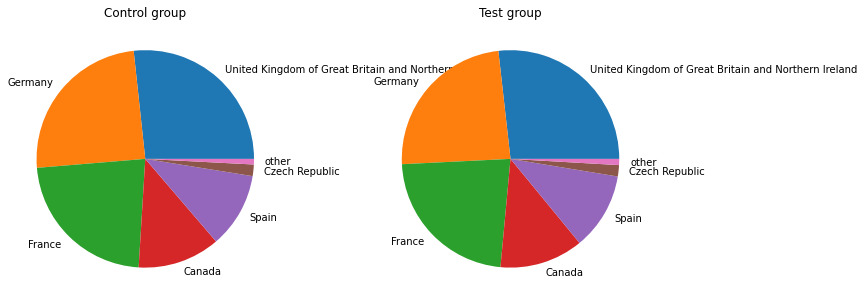

In [21]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1).set_title('Control group')
plt.pie(countries_control, labels = countries_control.index)

plt.subplot(1, 2, 2).set_title('Test group')
plt.pie(countries_test, labels = countries_test.index)
plt.show()

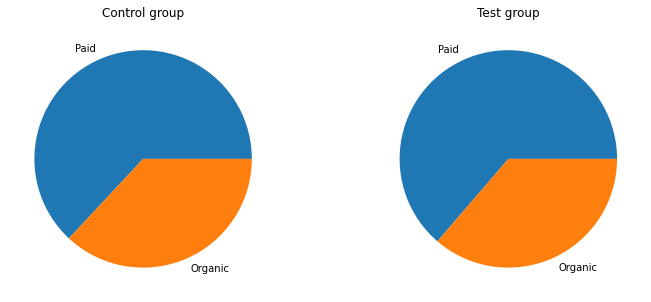

In [22]:
network_control = df_control['network_name'].value_counts()
network_test = df_test['network_name'].value_counts()

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1).set_title('Control group')
plt.pie(network_control, labels = network_control.index)

plt.subplot(1, 2, 2).set_title('Test group')
plt.pie(network_test, labels = network_test.index)
plt.show()

In [23]:
df_columns = ['InGameTime', 'LastCompletedLevel', 'avg_energy_amount']

In [24]:
df_control[df_columns].describe()

,InGameTime,LastCompletedLevel,avg_energy_amount
count,5.566750e+05,556675.000000,5.566750e+05
mean,2.300563e+06,425.446824,1.137473e+05
std,1.207453e+08,433.408672,1.545834e+07
min,-2.128381e+09,-1.000000,0.000000e+00
25%,3.323500e+04,59.000000,3.700000e+01
50%,1.732190e+05,245.000000,5.200000e+01
75%,5.056500e+05,734.000000,7.300000e+01
max,2.139124e+09,1299.000000,2.123448e+09


In [25]:
df_test[df_columns].describe()

,InGameTime,LastCompletedLevel,avg_energy_amount
count,1.378070e+05,137807.000000,1.378070e+05
mean,3.168126e+06,430.905781,2.918374e+05
std,1.225232e+08,438.523175,2.466136e+07
min,-2.120439e+09,-1.000000,0.000000e+00
25%,3.393900e+04,61.000000,3.700000e+01
50%,1.740630e+05,249.000000,5.200000e+01
75%,5.273240e+05,745.000000,7.300000e+01
max,2.138080e+09,1299.000000,2.101007e+09


### 1.3. Time of the experiment

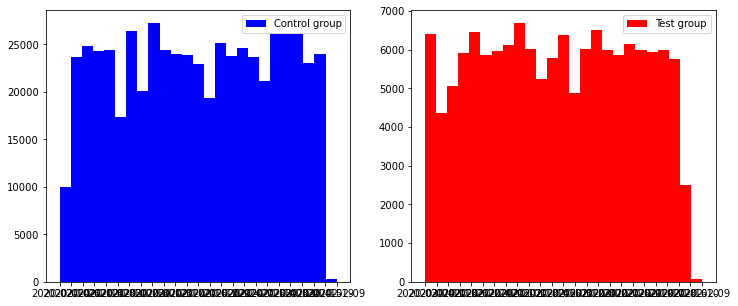

In [26]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_control['time_stamp'], bins = 25, color = 'b', label = 'Control group')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df_test['time_stamp'], bins = 25, color = 'r', label = 'Test group')
plt.legend()

plt.show()

In [27]:
df_control['time_stamp'].agg(['min', 'max'])

min    2020-02-09
max    2020-03-04
Name: time_stamp, dtype: object

In [28]:
df_test['time_stamp'].agg(['min', 'max'])

min    2020-02-09
max    2020-03-04
Name: time_stamp, dtype: object

In [29]:
print('The experiment lasted from {} to {}'.format(df_test['time_stamp'].min(), df_test['time_stamp'].max()))

The experiment lasted from 2020-02-09 to 2020-03-04


Experiment is conducted as expected

Data collection method was correct

# 2. Analysis

### 2.1. Conversion rate of the event

Exploration of how the conversion rate of gold_on_event, gold_on_other_activities has changed

In [30]:
df['event_converted'] = df['gold_on_event'].apply(lambda x: True if (x > 0) else False)

In [31]:
df.groupby(by = 'AbGroup')['event_converted'].value_counts()

AbGroup  event_converted
Control  False              520371
         True                36304
Test     False              128857
         True                 8950
Name: event_converted, dtype: int64

In [32]:
df_result = df.groupby(by = 'AbGroup')['event_converted'].agg(['sum', 'count']).reset_index()

In [33]:
df_result['cr'] = df_result['sum']/df_result['count']

In [34]:
df_result

,AbGroup,sum,count,cr
0,Control,36304,556675,0.065216
1,Test,8950,137807,0.064946


In [35]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1))/n1
    p2 = float(sum(sample2))/n2
    p = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / math.sqrt(p * (1-p) *(1./n1 + 1./n2))

In [36]:
def proportions_diff_z_test(z_stat):
    return 2 * (1 - scipy.stats.norm.cdf(abs(z_stat)))

In [37]:
z_stat = proportions_diff_z_stat_ind(df[df['AbGroup'] == 'Control']['event_converted'], df[df['AbGroup'] == 'Test']['event_converted'])

In [38]:
print('p-value: ', proportions_diff_z_test(z_stat))

p-value:  0.7162824368421443


Conversion rate (gold_on_event) did not change statistically significant

In [39]:
df['other_activities_converted'] = df['gold_on_other_activities'].apply(lambda x: True if (x > 0) else False)

In [40]:
df_result = df.groupby(by = 'AbGroup')['other_activities_converted'].agg(['sum', 'count']).reset_index()

In [41]:
df_result['cr'] = df_result['sum']/df_result['count']
df_result

,AbGroup,sum,count,cr
0,Control,134230,556675,0.241128
1,Test,33190,137807,0.240844


In [42]:
z_stat = proportions_diff_z_stat_ind(df[df['AbGroup'] == 'Control']['other_activities_converted'], df[df['AbGroup'] == 'Test']['other_activities_converted'])

In [43]:
print('p-value: ', proportions_diff_z_test(z_stat))

p-value:  0.825317503876905


Conversion rate (gold_on_other_activities) did not change statistically significant

### 2.2. Hypothesis testing. Metric: gold_on_event

#### 2.2.1. Changes in Test and Control groups

In [44]:
df_control['gold_on_event'].describe(percentiles = [0.25, 0.75, 0.99])

count     36304.000000
mean       1964.676069
std        3546.453117
min         500.000000
25%         500.000000
50%        1000.000000
75%        2400.000000
99%       12500.000000
max      180500.000000
Name: gold_on_event, dtype: float64

In [45]:
df_test['gold_on_event'].describe(percentiles = [0.25, 0.75, 0.99])

count      8950.000000
mean       2059.519553
std        4281.553987
min         500.000000
25%         500.000000
50%        1500.000000
75%        2400.000000
99%       12500.000000
max      189600.000000
Name: gold_on_event, dtype: float64

In [46]:
df[df['gold_on_event'].notna()].groupby('AbGroup')['gold_on_event'].agg(['mean', 'median']).reset_index()

,AbGroup,mean,median
0,Control,1964.676069,1000.0
1,Test,2059.519553,1500.0


We can observe, that mean and median increased in Test group. Let's check if it is statistically significant.

((array([-3.78309988, -3.55640642, -3.43187811, ...,  3.43187811,
          3.55640642,  3.78309988]),
  array([   500.,    500.,    500., ..., 156000., 165600., 189600.])),
 (2044.2217579613643, 2059.519553072625, 0.4772864364624959))

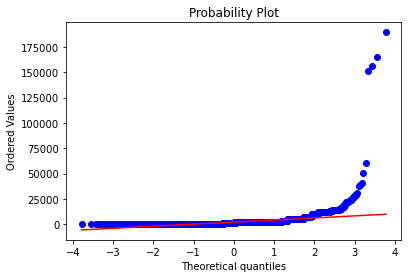

In [47]:
scipy.stats.probplot(df_test[df_test['gold_on_event'].notna()]['gold_on_event'], dist = 'norm', plot = plt)

The distibution of gold_on_event is not normal, let's use Mann-Whitney test.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [48]:
scipy.stats.mannwhitneyu(df[(df['AbGroup'] == 'Control') & (df['gold_on_event'].notna())]['gold_on_event'], df[(df['AbGroup'] == 'Test') & (df['gold_on_event'].notna())]['gold_on_event'])

MannwhitneyuResult(statistic=157939550.0, pvalue=1.4700817713681111e-05)

$H_0$ rejected. That value of gold_on_event changed statistically significant, pvalue=1.47e-05

#### 2.2.2. Bootstrap. Confidence interval for mean and median changes.

In [49]:
def get_bootstrap_samples(data, n_samples, len_sample):
    indices = np.random.randint(0, len(data), (n_samples, len_sample))
    samples = data[indices]
    return samples

In [50]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100*alpha/2., 100*(1 - alpha/2.)])
    return boundaries

In [51]:
gold_control = df[(df['AbGroup'] == 'Control') & (df['gold_on_event'].notna())]['gold_on_event'].values
gold_test = df[(df['AbGroup'] == 'Test') & (df['gold_on_event'].notna())]['gold_on_event'].values

In [52]:
gold_control_median = list(map(np.median, get_bootstrap_samples(gold_control, 10000, len(gold_control))))
gold_test_median = list(map(np.median, get_bootstrap_samples(gold_test, 10000, len(gold_test))))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(gold_control_median, gold_test_median)))

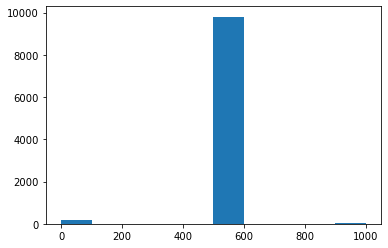

In [53]:
plt.hist(delta_median_scores)
plt.show()

In [54]:
stat_intervals(delta_median_scores, 0.05)

array([500., 500.])

In [58]:
gold_control_mean = list(map(np.mean, get_bootstrap_samples(gold_control, 10000, len(gold_control))))
gold_test_mean = list(map(np.mean, get_bootstrap_samples(gold_test, 10000, len(gold_test))))

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(gold_control_mean, gold_test_mean)))

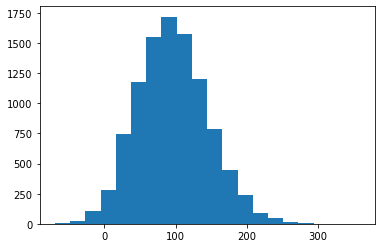

In [59]:
plt.hist(delta_mean_scores, bins = 20)
plt.show()

In [60]:
stat_intervals(delta_mean_scores, 0.05)

array([  6.2338599 , 196.35437037])

At significant level of 0.05, median increased by 500, mean increased by [  6.2338599 , 196.35437037].

#### 2.2.3. gold_on_event without extreme values

We can observe, that gold_on_event have extreme values that are far from our mean, may be they effect on mean

Let's check mean at Control and Test groups, without extreme values

In [61]:
percentile_99 = np.percentile(df[df['gold_on_event'].notna()]['gold_on_event'], 99)
percentile_99

12500.0

In [62]:
gold_control = df[(df['AbGroup'] == 'Control') & (df['gold_on_event'].notna()) & (df['gold_on_event'] <= percentile_99)]['gold_on_event'].values
gold_test = df[(df['AbGroup'] == 'Test') & (df['gold_on_event'].notna()) & (df['gold_on_event'] <= percentile_99)]['gold_on_event'].values

In [63]:
gold_control_mean = list(map(np.mean, get_bootstrap_samples(gold_control, 10000, len(gold_control))))
gold_test_mean = list(map(np.mean, get_bootstrap_samples(gold_test, 10000, len(gold_test))))

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(gold_control_mean, gold_test_mean)))

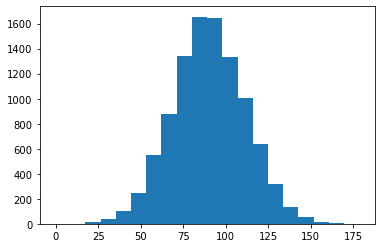

In [64]:
plt.hist(delta_mean_scores, bins = 20)
plt.show()

In [65]:
stat_intervals(delta_mean_scores, 0.05)

array([ 48.52662606, 132.39892056])

At significant level of 0.05, mean of gold_on_event without extreme values also increased by [ 48.52662606, 132.39892056].

### 2.3. Hypothesis testing. Metric: gold_on_other_activities

#### 2.3.1. Changes in Test and Control groups

In [66]:
df_control['gold_on_other_activities'].describe(percentiles = [0.25, 0.75, 0.99])

count    134230.000000
mean        906.109663
std        1648.766192
min         100.000000
25%         500.000000
50%         600.000000
75%        1000.000000
99%        5000.000000
max      400000.000000
Name: gold_on_other_activities, dtype: float64

In [67]:
df_test['gold_on_other_activities'].describe(percentiles = [0.25, 0.75, 0.99])

count     33190.000000
mean       1035.039168
std        7039.637069
min         100.000000
25%         500.000000
50%         600.000000
75%        1050.000000
99%        5100.000000
max      755950.000000
Name: gold_on_other_activities, dtype: float64

In [68]:
df[df['gold_on_other_activities'].notna()].groupby('AbGroup')['gold_on_other_activities'].agg(['mean', 'median']).reset_index()

,AbGroup,mean,median
0,Control,906.109663,600.0
1,Test,1035.039168,600.0


We can observe, that mean increased in Test group. Let's check if it is statistically significant.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [69]:
scipy.stats.mannwhitneyu(df[(df['AbGroup'] == 'Control') & (df['gold_on_other_activities'].notna())]['gold_on_other_activities'], df[(df['AbGroup'] == 'Test') & (df['gold_on_other_activities'].notna())]['gold_on_other_activities'])

MannwhitneyuResult(statistic=2200694140.0, pvalue=0.0005687346715917233)

$H_0$ rejected, the value of gold_on_other_activities changed statistically significant, pvalue=0.00056

#### 2.3.2. Bootstrap. Confidence interval for mean changes.

In [70]:
gold_control = df[(df['AbGroup'] == 'Control') & (df['gold_on_other_activities'].notna())]['gold_on_other_activities'].values
gold_test = df[(df['AbGroup'] == 'Test') & (df['gold_on_other_activities'].notna())]['gold_on_other_activities'].values

In [71]:
gold_control_mean = list(map(np.mean, get_bootstrap_samples(gold_control, 10000, len(gold_control))))
gold_test_mean = list(map(np.mean, get_bootstrap_samples(gold_test, 10000, len(gold_test))))

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(gold_control_mean, gold_test_mean)))

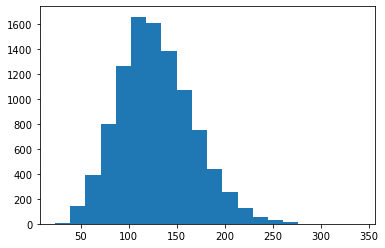

In [72]:
plt.hist(delta_mean_scores, bins = 20)
plt.show()

In [73]:
stat_intervals(delta_mean_scores, 0.05)

array([ 60.24558793, 210.9517964 ])

At significant level of 0.05, mean of gold_on_other_activities increased by [ 60.24558793, 210.9517964 ].

#### 2.3.3. gold_on_other_activities without extreme values

In [75]:
percentile_99_control = np.percentile(df[(df['AbGroup'] == 'Control') & df['gold_on_other_activities'].notna()]['gold_on_other_activities'], 99)
percentile_99_test = np.percentile(df[(df['AbGroup'] == 'Test') & df['gold_on_other_activities'].notna()]['gold_on_other_activities'], 99)

percentile_99_control, percentile_99_test

(5000.0, 5100.0)

In [76]:
gold_control = df[(df['AbGroup'] == 'Control') & (df['gold_on_other_activities'].notna()) & (df['gold_on_other_activities'] <= percentile_99_control)]['gold_on_other_activities'].values
gold_test = df[(df['AbGroup'] == 'Test') & (df['gold_on_other_activities'].notna()) & (df['gold_on_other_activities'] <= percentile_99_test)]['gold_on_other_activities'].values

In [77]:
gold_control_mean = list(map(np.mean, get_bootstrap_samples(gold_control, 10000, len(gold_control))))
gold_test_mean = list(map(np.mean, get_bootstrap_samples(gold_test, 10000, len(gold_test))))

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(gold_control_mean, gold_test_mean)))

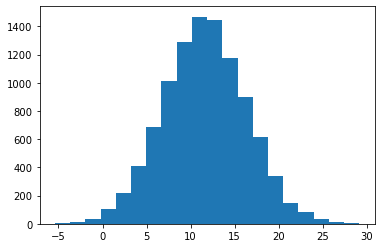

In [78]:
plt.hist(delta_mean_scores, bins = 20)
plt.show()

In [79]:
stat_intervals(delta_mean_scores, 0.05)

array([ 2.34039439, 20.89043011])

At a significant level of 0.05, mean of gold_on_other_activities without extreme values increased by [ 2.34039439, 20.89043011].

# 3. Conclusion

+ The Test group performed better.
+ Experiment positive and statistically significantly changed gold_on_event:
  median increased from 1000 to 1500
  + 95% Confidence interval for mean changes: [  6.2338599 , 196.35437037]
  + 95% Confidence interval for mean of gold_on_event without extreme values (<= 99 percentile): [ 48.52662606, 132.39892056]
+ Experiment positive and statistically significantly changed gold_on_other_activities
  + 95% Confidence interval for mean changes: [ 60.24558793, 210.9517964 ]

+ Experiment launch is recommended.